In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import fastai
fastai.__version__

'2.1.8'

In [5]:
import numpy as np
import torch
from fastai import *
from fastai.vision.all import *
from fastai.callback.all import *

In [6]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [7]:
path = Path('/kaggle/input/cassava-leaf-disease-classification')
train = path /"train.csv"
train_df = pd.read_csv(train)
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:
train_df.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

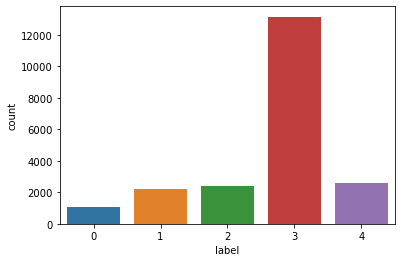

In [8]:
import seaborn as sns
sns.countplot(train_df.label)
plt.show()

In [9]:
item_tfms = Resize(256)
batch_tfms = [RandomResizedCrop(224), *aug_transforms(mult=1.0, do_flip=True, max_rotate=30.0, max_zoom=1.5,
                            max_lighting=.8, max_warp=0.3, p_lighting=.9)]

In [10]:
dls = ImageDataLoaders.from_df(train_df, path/"train_images", 
                              item_tfms=item_tfms,
                              batch_tfms = batch_tfms,
                              bs=64, num_workers=4, 
                              label_col="label")

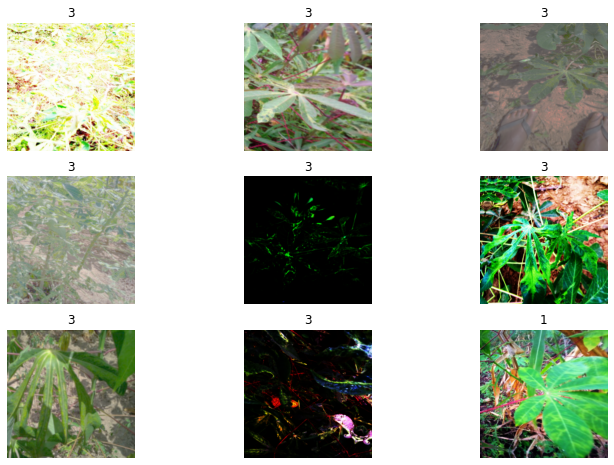

In [11]:
dls.show_batch(max_n=9,figsize=(12,8))

In [12]:
# category names, number of categories
print(dls.vocab); print(dls.c)

[0, 1, 2, 3, 4]
5


In [11]:
learn = cnn_learner(dls, resnet34, metrics=[FBeta(beta=1, average='macro'),accuracy], cbs=MixUp, model_dir="/tmp/model/").to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [12]:
learn.fit_one_cycle(15, lr_max=1e-2, cbs=EarlyStoppingCallback(patience=3))

epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,1.343289,0.815961,0.537865,0.704604,04:33
1,1.026181,0.832557,0.566029,0.696191,04:24
2,0.991521,0.819726,0.428445,0.709278,04:25
3,0.907225,0.604388,0.617972,0.788736,04:27
4,0.860978,0.571695,0.607888,0.797616,04:23
5,0.889071,0.569070,0.651034,0.804160,04:20
6,0.845887,0.692907,0.574297,0.742463,04:20
7,0.821566,0.553739,0.673514,0.819117,04:18
8,0.817914,0.552388,0.651779,0.798317,04:17
9,0.829097,0.536099,0.682540,0.818649,04:15


In [13]:
learn.fine_tune(5, cbs=[EarlyStoppingCallback(patience=3)])

epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.766413,0.488382,0.732117,0.838747,04:19


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.781033,0.541405,0.692048,0.816312,04:20
1,0.802374,0.480691,0.705578,0.835242,04:19
2,0.768683,0.511170,0.718210,0.829867,04:20
3,0.752542,0.443813,0.735985,0.852068,04:19
4,0.731258,0.451598,0.736822,0.848095,04:22


SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=7.585775847473997e-07)

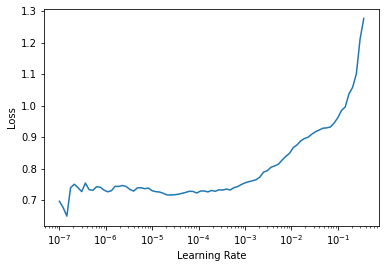

In [14]:
learn.lr_find()

In [15]:
learn.save('model_stage_1')

Path('/tmp/model/model_stage_1.pth')

In [16]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(15, lr_max=slice(1e-7, 1e-3), cbs=EarlyStoppingCallback(patience=2))

epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.741721,0.444911,0.737420,0.848563,04:21
1,0.755883,0.444297,0.741223,0.850900,04:24
2,0.737561,0.440941,0.742639,0.853003,04:18
3,0.744753,0.435690,0.748536,0.854639,04:17
4,0.746752,0.441028,0.741883,0.854172,04:19
5,0.732428,0.432331,0.746158,0.854405,04:18
6,0.732531,0.429718,0.744591,0.856509,04:17
7,0.707937,0.436333,0.746515,0.850432,04:24
8,0.728682,0.434882,0.740287,0.851133,04:21


No improvement since epoch 6: early stopping


In [19]:
sub_df = pd.read_csv(path/'sample_submission.csv')
sub_df.head()

,image_id,label
0,2216849948.jpg,4


In [23]:
preds,targs = learn.tta()
print(accuracy(preds, targs).item())

0.8621172904968262


**CrossValidation**

In [8]:
def get_dls(bs, size, val_idx):
    item_tfms = Resize(256)
    batch_tfms = [RandomResizedCrop(size), *aug_transforms(mult=1.0, do_flip=True, max_rotate=30.0, max_zoom=1.5,
                            max_lighting=.8, max_warp=0.3, p_lighting=.9)]
    dls = ImageDataLoaders.from_df(train_df, path/"train_images", 
                              splitter=IndexSplitter(val_idx),
                              item_tfms=item_tfms,
                              batch_tfms = batch_tfms,
                              bs=bs, num_workers=4, 
                              label_col="label")
    return dls

In [9]:
for train_idx, val_idx in skf.split(train_df['image_id'].values, train_df['label'].values):
    print(train_idx, val_idx)

[    0     2     3 ... 21394 21395 21396] [    1    10    12 ... 21381 21388 21393]
[    0     1     4 ... 21394 21395 21396] [    2     3    13 ... 21367 21380 21390]
[    0     1     2 ... 21393 21395 21396] [    5     8    43 ... 21386 21392 21394]
[    1     2     3 ... 21392 21393 21394] [    0     6    11 ... 21391 21395 21396]
[    0     1     2 ... 21394 21395 21396] [    4     7     9 ... 21363 21371 21383]


In [10]:
from sklearn.model_selection import StratifiedKFold
val_pct = []
skf = StratifiedKFold(n_splits=3, shuffle=True)
i = 0

for _, val_idx in skf.split(train_df['image_id'].values, train_df['label'].values):
  dls = get_dls(32, 128, val_idx)
  learn = cnn_learner(dls, resnet34, metrics=[FBeta(beta=1, average='macro'),accuracy], cbs=MixUp, model_dir="/tmp/model/").to_fp16()
  learn.fine_tune(2, cbs=EarlyStoppingCallback(patience=2))
  learn.dls = get_dls(32, 224, val_idx)
  learn.fine_tune(5, 1e-3, cbs=EarlyStoppingCallback(patience=2))
  preds,targs = learn.tta()
  print(accuracy(preds, targs).item())
  val_pct.append(accuracy(preds, targs).item())
  i+=1

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,1.195110,0.825596,0.486573,0.691750,04:41


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.920035,0.649643,0.618415,0.769105,04:27
1,0.847299,0.523431,0.703221,0.827997,04:24


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.817100,0.537787,0.680964,0.811405,04:18


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.795026,0.521556,0.696382,0.823089,04:25
1,0.757613,0.594226,0.672838,0.796214,04:24
2,0.789008,0.501628,0.715656,0.835476,04:25
3,0.746095,0.474869,0.725893,0.843421,04:24
4,0.740981,0.471629,0.730362,0.844824,04:30


0.8448235392570496


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,1.216924,0.860999,0.484132,0.687544,04:16


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.917273,0.598999,0.640117,0.791073,04:26
1,0.828873,0.539748,0.678378,0.812106,04:30


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.815733,0.542641,0.692016,0.804160,04:18


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.851481,0.510890,0.697004,0.824024,04:27
1,0.822862,0.460138,0.724430,0.848329,04:27
2,0.780212,0.478561,0.720447,0.837345,04:29
3,0.767389,0.432789,0.750395,0.859313,04:28
4,0.749832,0.416108,0.758194,0.863052,04:29


0.8714653253555298


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,1.205453,0.890044,0.479499,0.667446,04:16


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.901534,0.716959,0.606485,0.730545,04:24
1,0.823910,0.534536,0.675036,0.813975,04:26


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.844544,0.540782,0.682160,0.814443,04:17


epoch,train_loss,valid_loss,fbeta_score,accuracy,time
0,0.833436,0.488578,0.705642,0.837345,04:26
1,0.820966,0.532849,0.670889,0.810236,04:25
2,0.814879,0.449586,0.731142,0.848796,04:25
3,0.770791,0.448567,0.734341,0.847862,04:24
4,0.773550,0.417168,0.746506,0.859780,04:24


0.8665575981140137


**Inference**

In [11]:
get_image_files(path/"test_images")

(#1) [Path('/kaggle/input/cassava-leaf-disease-classification/test_images/2216849948.jpg')]

In [12]:
test_items = get_image_files(path/"test_images")
dl = learn.dls.test_dl(test_items, rm_type_tfms=1, bs=64)
y_pred, _ = learn.get_preds(dl=dl)

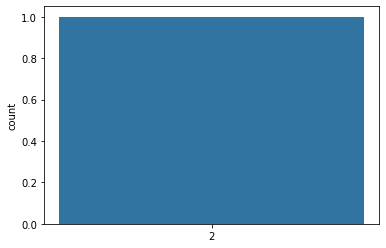

In [14]:
test_items = get_image_files(path/"test_images")
dl2 = learn.dls.test_dl(test_items)
test_preds = learn.get_preds(dl=dl2)
predictions = []
for pred in test_preds[0]:
    predictions.append(pred.argmax().item())
#
import seaborn as sns
sns.countplot(predictions)
plt.show()

In [16]:
sub_df = pd.read_csv(path/'sample_submission.csv')

In [17]:
sub_df['label'] = y_pred.argmax(dim=-1).numpy()
sub_df.head()

,image_id,label
0,2216849948.jpg,2


In [18]:
y_pred

tensor([[-2.3789, -1.6387,  2.5215,  0.9165,  0.7686]])

In [19]:
PATH = "/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json"
PATH

'/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json'

In [20]:
import json
# Opening JSON file 
f = open(PATH,) 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 
  
print(data)
print(type(data))
  
# Closing file 
f.close() 

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}
<class 'dict'>


In [21]:
lb =y_pred.argmax(dim=-1).numpy().tolist()[0]

In [22]:
print(f"The Label predicted for the image {sub_df['image_id'].values.tolist()[0]} is : {data[str(lb)]}")

The Label predicted for the image 2216849948.jpg is : Cassava Green Mottle (CGM)


In [23]:
sub_df.head()

,image_id,label
0,2216849948.jpg,2


In [24]:
sub_df.to_csv('/kaggle/working/submission.csv',index=False)